In [2]:
pip install opencv-python pixellib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print('슝=3')

슝=3


In [4]:
home_dir = os.getenv('HOME')
img_path = os.path.join(home_dir, "work/human_segmentation/images/cat_img.png")
img_orig = cv2.imread(img_path)


print(f"이미지 크기: {img_orig.shape}")

이미지 크기: (957, 1400, 3)


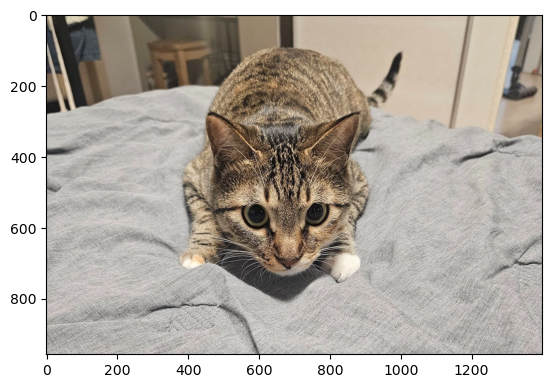

In [5]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights

model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT).eval()
print("완료")

완료


In [7]:
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기 (고정)
    T.ToTensor(),
])

In [8]:
input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

In [9]:
%%time
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

CPU times: user 8.72 s, sys: 67 ms, total: 8.78 s
Wall time: 8.85 s


In [10]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

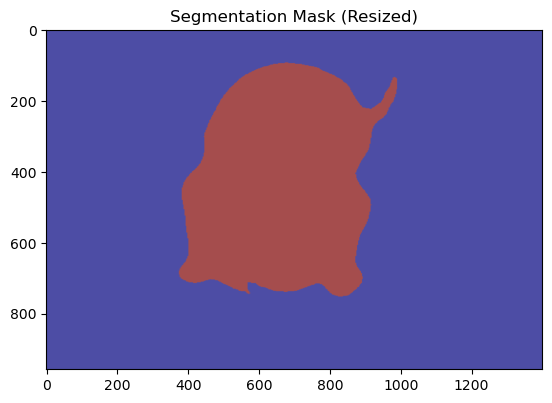

In [11]:
plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

In [12]:
unique_classes = np.unique(output_predictions_resized)
unique_classes

array([0, 8], dtype=uint8)

In [13]:
for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

background
cat


In [14]:
#컬러맵 만들기
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]  # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [15]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

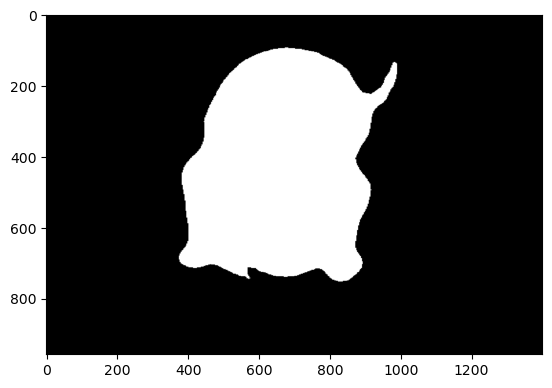

In [16]:
seg_map = (output_predictions_resized == 8)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

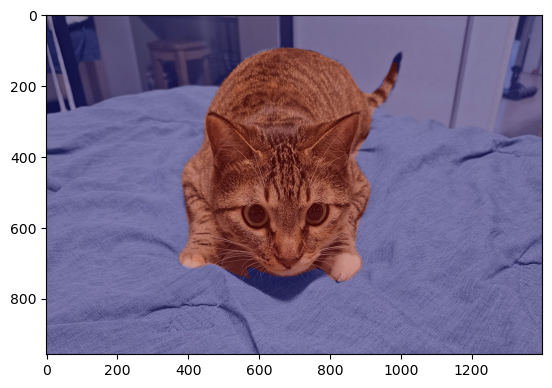

In [17]:
img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

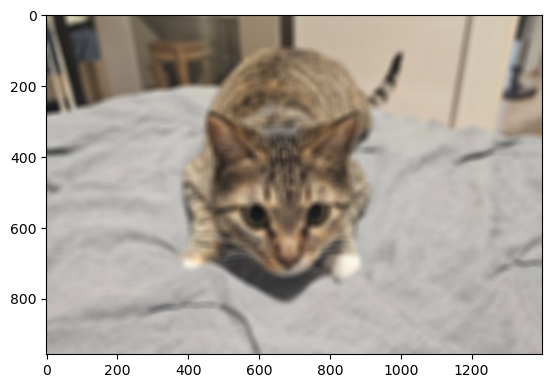

In [18]:
img_orig_blur = cv2.blur(img_orig, (20, 20))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
# 1. 원하는 배경 이미지 경로를 지정하세요. (경로는 예시입니다)
# img_orig 변수를 불러왔던 셀의 home_dir 변수를 사용합니다.
bg_img_path = os.path.join(home_dir, "work/human_segmentation/images/desert.png") 
img_bg = cv2.imread(bg_img_path)

# 2. 원본 이미지(img_orig) 크기에 맞게 배경 이미지 크기를 조절합니다.
img_bg = cv2.resize(img_bg, (img_orig.shape[1], img_orig.shape[0]))

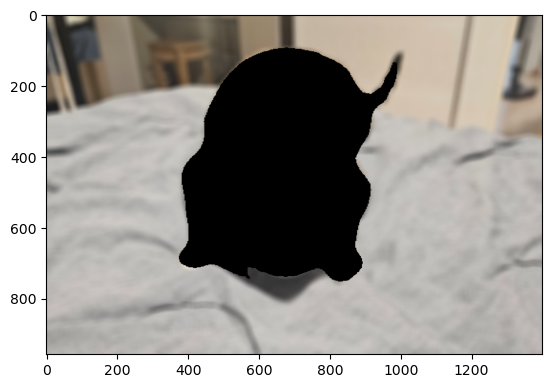

In [20]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

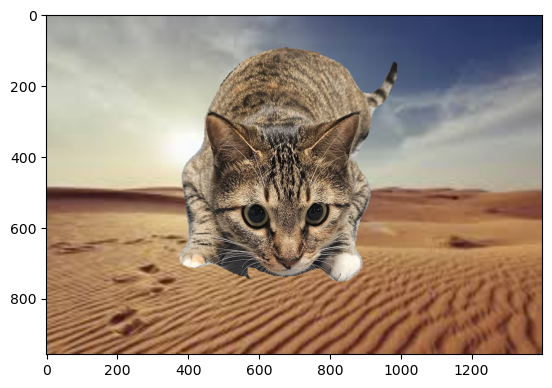

In [24]:
img_concat = np.where(img_mask_color == 255, img_orig, img_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

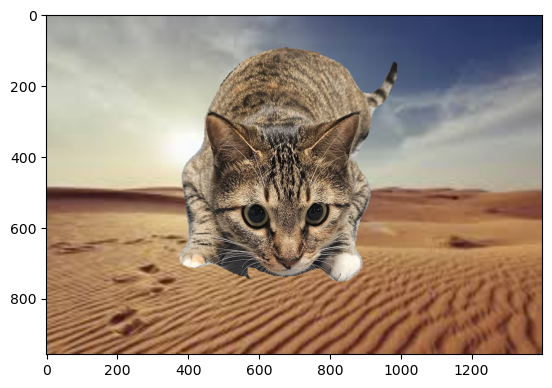

In [25]:
img_concat = np.where(img_mask_color == 255, img_orig, img_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()